# Phase 1 : Business Understanding
Le jeu de données Uber contient des informations sur chaque trajet, telles que le point de départ et d’arrivée, l’heure du trajet, le nombre de passagers et le coût. L’objectif de l’utilisation de ces données est d’aider Uber de deux manières : d’une part, en prédisant combien coûtera un trajet, et d’autre part, en comprenant les tendances des trajets afin d’améliorer les services et la prise de décision.

## 1. Business objective 1 :
Uber souhaite fournir aux passagers des estimations de coût précises avant la réservation d’un trajet. Cela améliore la confiance et la satisfaction des clients en évitant les coûts imprévus, et aide les passagers à prendre des décisions éclairées.

## 2. Business Objective 2 :
Uber souhaite également acquérir des connaissances sur le comportement des trajets en identifiant des motifs et en regroupant les trajets similaires. Cela permet de mieux comprendre la segmentation du marché et de détecter des anomalies ou des fraudes.

### Data Science Objective 1 (Supervisé) :
Développer un modèle supervisé pour prédire la variable du coût du trajet en se basant sur les caractéristiques du jeu de données.

### Data Science Objective 2 (Non supervisé) :
Appliquer des techniques d’apprentissage non supervisé (clustering) pour regrouper les trajets en fonction de caractéristiques telles que la distance du trajet, l’heure de la journée et le nombre de passagers. L’objectif est de révéler des structures cachées dans les données, de détecter des valeurs aberrantes et de fournir des insights exploitables pour l’entreprise, allant au-delà de la simple prédiction des tarifs.

# Phase 2 : Data Understanding :

In [172]:
import pandas as pd
import numpy as np
from math import radians, cos, sin, asin, sqrt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
from sklearn.neighbors import KNeighborsRegressor
%matplotlib inline
from sklearn.cluster import KMeans
from xgboost import XGBRegressor

In [3]:
df = pd.read_csv("Data/datauber.csv")
print("Dataset shape:", df.shape)

Dataset shape: (44377, 9)


In [4]:
df.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194.0,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1.0
1,27835199.0,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1.0
2,44984355.0,2009-08-24 21:45:00.00000061,12.9,NaN,-74.005043,40.740770,NaN,40.772647,1.0
3,25894730.0,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,NaN,-73.965316,40.803349,3.0
4,17610152.0,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,NaN,40.744085,-73.973082,NaN,5.0


The datset contains the following fields:
* key - a unique identifier for each trip
* fare_amount - the cost of each trip in usd
* pickup_datetime - date and time when the meter was engaged
* passenger_count - the number of passengers in the vehicle (driver entered value)
* pickup_longitude - the longitude where the meter was engaged
* pickup_latitude - the latitude where the meter was engaged
* dropoff_longitude - the longitude where the meter was disengaged
* dropoff_latitude - the latitude where the meter was disengaged

In [6]:
df.info

<bound method DataFrame.info of        Unnamed: 0                            key  fare_amount  \
0      24238194.0    2015-05-07 19:52:06.0000003          7.5   
1      27835199.0    2009-07-17 20:04:56.0000002          7.7   
2      44984355.0   2009-08-24 21:45:00.00000061         12.9   
3      25894730.0    2009-06-26 08:22:21.0000001          5.3   
4      17610152.0  2014-08-28 17:47:00.000000188         16.0   
...           ...                            ...          ...   
44372  35522961.0    2013-09-28 01:30:18.0000001         21.5   
44373  34717029.0    2014-03-28 19:28:34.0000005          5.0   
44374  51028248.0    2011-03-30 12:54:23.0000005          9.3   
44375  50834096.0                            NaN          4.9   
44376  15145716.0    2012-07-12 00:59:02.0000002          3.3   

               pickup_datetime  pickup_longitude  pickup_latitude  \
0      2015-05-07 19:52:06 UTC        -73.999817        40.738354   
1      2009-07-17 20:04:56 UTC        -73.994355 

In [7]:
print("Variable Types in the Dataset:")
df.dtypes

Variable Types in the Dataset:


Unnamed: 0           float64
key                   object
fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count      float64
dtype: object

**la plupart des variables sont de type numérique avec deux variables de type objet (Key, pickup-datetime) qui sont des dates.**

## Analyse statistique

In [10]:
display(df.describe())

,Unnamed: 0,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,4.224300e+04,42217.000000,42183.000000,42130.000000,42183.000000,42119.000000,42159.000000
mean,2.767290e+07,11.409233,-72.568666,39.948790,-72.588555,39.957229,1.677720
std,1.602678e+07,10.091979,10.776933,6.006307,10.684628,5.962407,1.296484
min,4.800000e+01,0.000000,-748.016667,-74.015515,-737.916665,-74.008745,0.000000
25%,1.372484e+07,6.000000,-73.992075,40.734808,-73.991496,40.733766,1.000000
50%,2.765192e+07,8.500000,-73.981857,40.752503,-73.980170,40.752910,1.000000
75%,4.151020e+07,12.600000,-73.967187,40.767077,-73.963738,40.768162,2.000000
max,5.542169e+07,350.000000,40.774042,45.031653,40.828377,45.031598,6.000000


### 1. fare amount (variable cible) : 

  * Moyenne : 11.4dollars => prix moyen d’une course.

  * Médiane (50%) : 8.5dollars => la moitié des courses coûtent moins de 8.5 dollars .

  * Max : 350 dollars => valeurs très élevées (probablement anomalies ou trajets longs à vérifier).

  * Écart-type : 10 dollars → variabilité importante.
=> il existe certaines valeurs aberrantes existent (course à 0 dollar, ou > 200 dollars).

### 2. pickup_longitude & pickup_latitude

La majorité des points sont autour de (-73, 40.7) → ce qui correspond à New York City.

Mais il y a des valeurs aberrantes :

Longitude min = -748 (!), Latitude min = -74 → impossible, erreur de saisie.

IQR (25%–75%) montre que les points corrects sont bien centrés autour de NYC.
### 3. dropoff_longitude & dropoff_latitude

Même logique que pickup → valeurs réalistes autour de NYC.

Mais présence d’anomalies (ex : longitude = -737, impossible).
### 4. passenger_count

Moyenne = 1.67 passagers → la majorité des courses sont solo.

Médiane = 1 passager.

Min = 0 → incohérent (erreur de saisie à vérifier).

Max = 6 → correspond probablement à la capacité maximale d’un taxi.

## Conclusion

Le dataset contient des valeurs aberrantes (coordonnées impossibles, prix = 0, passagers = 0).

La majorité des courses sont :

1 ou 2 passagers

Prix entre 6 dollars et 13 dollars

Coordonnées autour de NYC

## Missing values : 

In [13]:
df.isnull().sum()

Unnamed: 0           2134
key                  2234
fare_amount          2160
pickup_datetime      2283
pickup_longitude     2194
pickup_latitude      2247
dropoff_longitude    2194
dropoff_latitude     2258
passenger_count      2218
dtype: int64

In [14]:
total_missing_values = df.isnull().sum().sum()
print(f"Total Number of Missing values : {total_missing_values}")

Total Number of Missing values : 19922


## Histogrammes :
### 1. Fare_amount distribution :

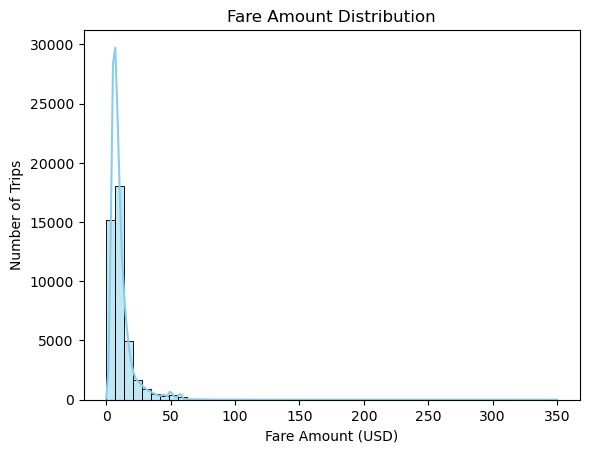

In [16]:
sns.histplot(df['fare_amount'], bins=50, kde=True, color='skyblue')
plt.title('Fare Amount Distribution')
plt.xlabel('Fare Amount (USD)')
plt.ylabel('Number of Trips')
plt.show()

**Interpretation :**
The histogram shows that most fares are between 5 and 20 USD.
There are some extremely low fares (0 USD) and some very high fares (>100 USD), which are likely outliers or data entry errors.

### 2. Passenger_count distribution :

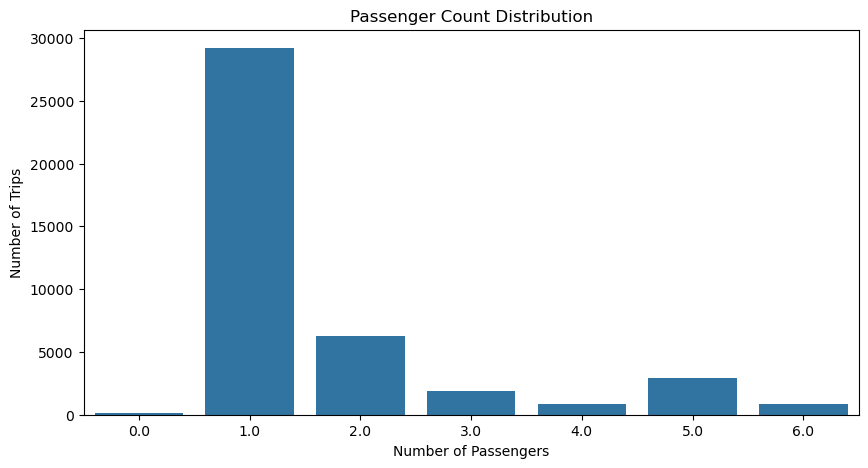

In [19]:
plt.figure(figsize=(10,5))
sns.countplot(x='passenger_count', data=df)
plt.title('Passenger Count Distribution')
plt.xlabel('Number of Passengers')
plt.ylabel('Number of Trips')
plt.show()

**Interpretation:**
Most trips have 1 or 2 passengers.  
There are a few trips with 0 passengers or more than 4, which are inconsistent and indicate errors in the dataset.

### 3. Average fare by passenger count :

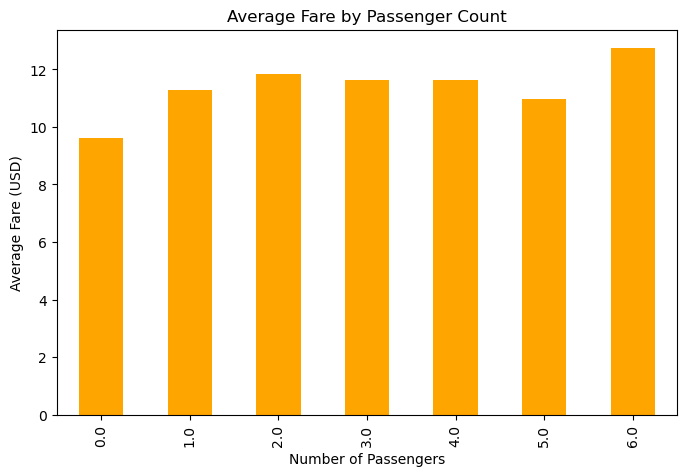

In [22]:
passenger_fares = df.groupby("passenger_count")["fare_amount"].mean()

plt.figure(figsize=(8,5))
passenger_fares.plot(kind="bar", color='orange')
plt.xlabel("Number of Passengers")
plt.ylabel("Average Fare (USD)")
plt.title("Average Fare by Passenger Count")
plt.show()

**Interpretation:**
The average fare generally increases with the number of passengers, which is expected.
Trips with 0 passengers show unusual average fares, confirming that these rows are likely errors

### 4. Pickup datetime analysis :

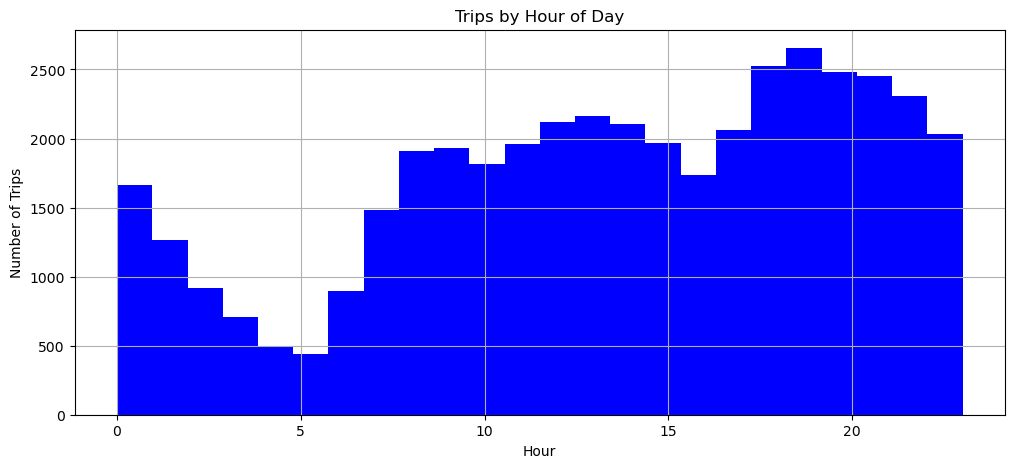

In [25]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], errors='coerce')
plt.figure(figsize=(12,5))
df['pickup_datetime'].dt.hour.hist(bins=24, color='b')
plt.title('Trips by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Number of Trips')
plt.show()

**Interpretation:**
Most trips occur between 8 AM and 8 PM, with peaks during morning and evening rush hours.
There are very few trips late at night (0-5 AM).

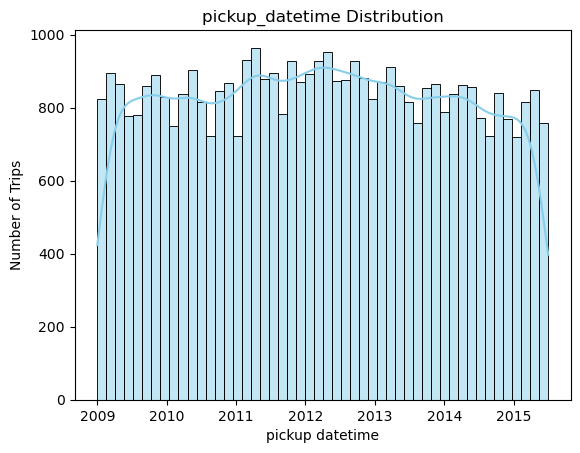

In [27]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
sns.histplot(df['pickup_datetime'], bins=50, kde=True, color='skyblue')
plt.title('pickup_datetime Distribution')
plt.xlabel('pickup datetime')
plt.ylabel('Number of Trips')
plt.show()

**Interpretation :**
The pickup datetime distribution shows that Uber trips increased steadily from 2009 to 2015, reflecting growing demand and expanding service over time.

### 5. Trips by Day :

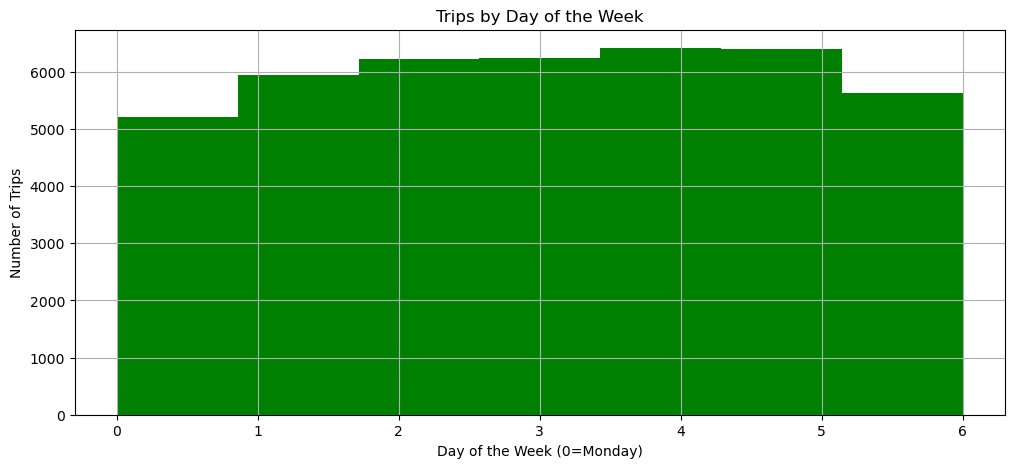

In [30]:
plt.figure(figsize=(12,5))
df['pickup_datetime'].dt.dayofweek.hist(bins=7, color='green')
plt.title('Trips by Day of the Week')
plt.xlabel('Day of the Week (0=Monday)')
plt.ylabel('Number of Trips')
plt.show()

**Interpretation:**
Trips are fairly evenly distributed across weekdays. Slightly fewer trips occur on weekends. 

## Boxplots

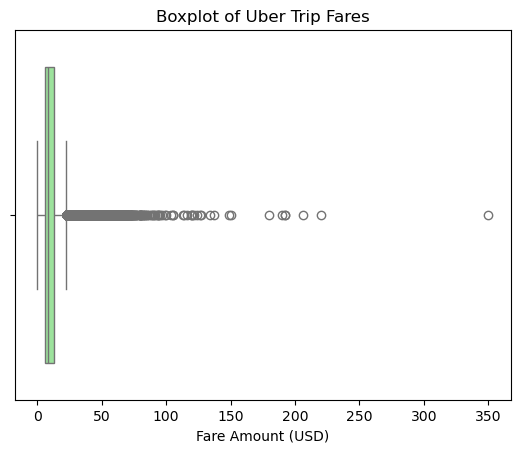

In [33]:
sns.boxplot(x=df['fare_amount'], color='lightgreen')
plt.title('Boxplot of Uber Trip Fares')
plt.xlabel('Fare Amount (USD)')
plt.show()

**Interpretation:**
Outliers with extremely high fares are visible. Median fare is around 12-15 USD.

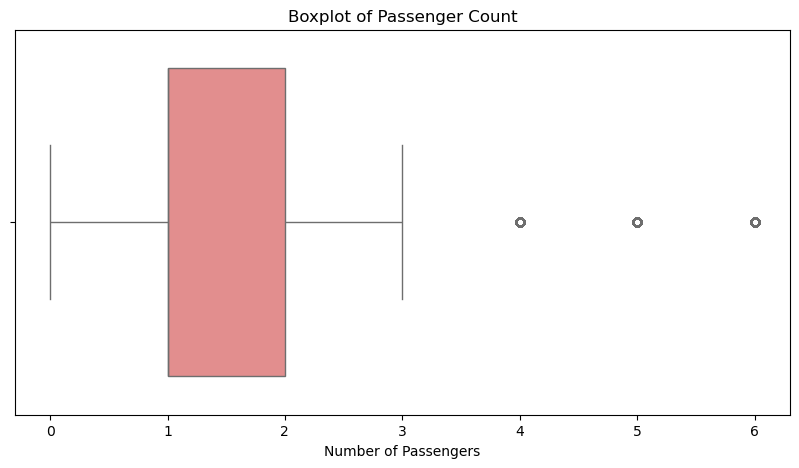

In [35]:
plt.figure(figsize=(10,5))
sns.boxplot(x=df['passenger_count'], color='lightcoral')
plt.title('Boxplot of Passenger Count')
plt.xlabel('Number of Passengers')
plt.show()

**Interpretation:**
Most trips have 1 or 2 passengers. Zero passengers are considered errors and will be removed later.

# Phase 3 : Data Preparation 

## 1. Missing Values :

In [39]:
total_missing = df.isnull().sum().sum()
print(f"Nombre total de valeurs manquantes : {total_missing}")

Nombre total de valeurs manquantes : 19922


In [40]:
for col in df.columns:
    percentage_values = df[col].isnull().mean() * 100 
    print(f"{col}: {percentage_values:.2f}%")

Unnamed: 0: 4.81%
key: 5.03%
fare_amount: 4.87%
pickup_datetime: 5.14%
pickup_longitude: 4.94%
pickup_latitude: 5.06%
dropoff_longitude: 4.94%
dropoff_latitude: 5.09%
passenger_count: 5.00%


In [41]:
print("NUMERIC VARIABLES:")
num_var = df._get_numeric_data().columns
for col in num_var:
    print(col)

NUMERIC VARIABLES:
Unnamed: 0
fare_amount
pickup_longitude
pickup_latitude
dropoff_longitude
dropoff_latitude
passenger_count


In [42]:
for col in num_var:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    borne_basse = Q1 - 1.5 * IQR
    borne_haute = Q3 + 1.5 * IQR

    outliers = df[(df[col] < borne_basse) | (df[col] > borne_haute)]
    print(f"Nombre de valeurs extrêmes dans {col} :", outliers.shape[0])

Nombre de valeurs extrêmes dans Unnamed: 0 : 0
Nombre de valeurs extrêmes dans fare_amount : 3545
Nombre de valeurs extrêmes dans pickup_longitude : 2913
Nombre de valeurs extrêmes dans pickup_latitude : 1954
Nombre de valeurs extrêmes dans dropoff_longitude : 3023
Nombre de valeurs extrêmes dans dropoff_latitude : 2563
Nombre de valeurs extrêmes dans passenger_count : 4659


In [43]:
for col in num_var:
    mediane = df[col].median()
    df[col]=df[col].fillna(mediane)
    print(col, df[col].isnull().sum())

Unnamed: 0 0
fare_amount 0
pickup_longitude 0
pickup_latitude 0
dropoff_longitude 0
dropoff_latitude 0
passenger_count 0


In [44]:
print("CATEGORICAL VARIABLES:")
cat_var = df.select_dtypes(include=['object','datetime64[ns, UTC]']).columns
for col in cat_var:
    print(col)

CATEGORICAL VARIABLES:
key
pickup_datetime


In [45]:
for col in cat_var:
    mode_val = df[col].mode()[0]
    df[col] = df[col].fillna(mode_val)
    print(col, df[col].isnull().sum())

key 0
pickup_datetime 0


In [46]:
total_missing = df.isnull().sum().sum()
print(f"Nombre total de valeurs manquantes : {total_missing}")

Nombre total de valeurs manquantes : 0


### 2. Supprission de la colonne unnamed :

In [48]:
df = df.drop(columns=["Unnamed: 0"])

### 3. Suppression des cordonnées GPS invalides et passenger_count invalide) : 

In [50]:
df = df[~((df['pickup_longitude'] == 0) & (df['pickup_latitude'] == 0))]
df = df[~((df['dropoff_longitude'] == 0) & (df['dropoff_latitude'] == 0))]
outliers_pickup = df[(df['pickup_longitude'] < -180) | (df['pickup_longitude'] > 180)]
outliers_dropoff = df[(df['dropoff_longitude'] < -180) | (df['dropoff_longitude'] > 180)]
print("Pickup longitude hors bornes :", len(outliers_pickup))
print("Dropoff longitude hors bornes :", len(outliers_dropoff))

Pickup longitude hors bornes : 1
Dropoff longitude hors bornes : 1


In [51]:
outliers_pickup = df[(df['pickup_latitude'] < -90) | (df['pickup_latitude'] > 90)]
outliers_dropoff = df[(df['dropoff_latitude'] < -90) | (df['dropoff_latitude'] > 90)]
print("Pickup latitude hors bornes :", len(outliers_pickup))
print("Dropoff latitude hors bornes :", len(outliers_dropoff))

Pickup latitude hors bornes : 0
Dropoff latitude hors bornes : 0


In [52]:
df = df[~(df['passenger_count'] == 0)]

**key peut être duppliqué puisqu'il est composé de date et temps
Suppression des doublons exacts (mêmes valeurs dans toutes les colonnes)**

In [54]:
df = df.drop_duplicates()

### 4.Correction des Prix aberrants : 

In [56]:
df = df[~(df['fare_amount'] >= 130)]

# Feature engineering
### change latitude and longitude to distance
### change pickup_datetime to hours and days columns

In [58]:
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    km = 6371 * c
    return km

In [59]:
df['distance_km'] = df.apply(lambda row: haversine(
    row['pickup_longitude'], row['pickup_latitude'],
    row['dropoff_longitude'], row['dropoff_latitude']), axis=1)

In [60]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], errors='coerce')

In [61]:
df['pickup_hour'] = df['pickup_datetime'].dt.hour
df['pickup_dow'] = df['pickup_datetime'].dt.dayofweek  
df['is_weekend'] = df['pickup_dow'].isin([5,6]).astype(int)

In [62]:
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_km,pickup_hour,pickup_dow,is_weekend
0,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1.0,1.683323,19,3,0
1,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1.0,2.457590,20,4,0
2,2009-08-24 21:45:00.00000061,12.9,2009-01-11 13:07:00+00:00,-74.005043,40.740770,-73.980170,40.772647,1.0,4.117407,13,6,1
3,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.752503,-73.965316,40.803349,3.0,5.726622,8,4,0
4,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00+00:00,-73.981857,40.744085,-73.973082,40.752910,5.0,1.228574,17,3,0


# verification de la colonne distance_km

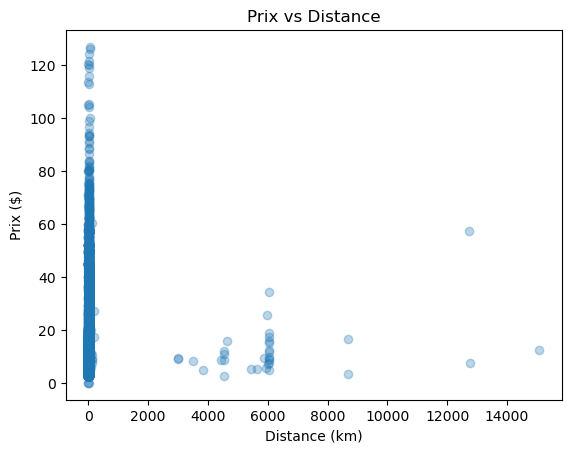

In [64]:
plt.scatter(df['distance_km'], df['fare_amount'], alpha=0.3)
plt.xlabel('Distance (km)')
plt.ylabel('Prix ($)')
plt.title('Prix vs Distance')
plt.show()

**supprimer les valeurs abberantes dans la colonne distance_km**

In [66]:
df= df[df['distance_km']<100]

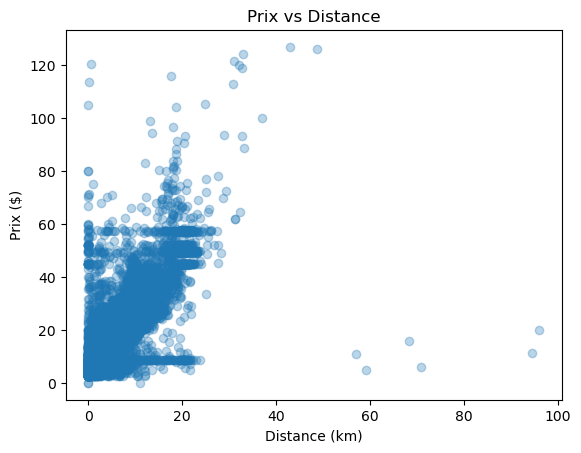

In [67]:
plt.scatter(df['distance_km'], df['fare_amount'], alpha=0.3)
plt.xlabel('Distance (km)')
plt.ylabel('Prix ($)')
plt.title('Prix vs Distance')
plt.show()

In [68]:
df['price_per_km'] = np.where(
    df['distance_km'] < 1,
    df['fare_amount'],                          # if distance < 0.1
    df['fare_amount'] / df['distance_km']       # else
)
print(df['price_per_km'].describe()) 

count    43266.000000
mean         4.171989
std          2.960360
min          0.000000
25%          2.886786
50%          3.707200
75%          4.746613
max        120.300000
Name: price_per_km, dtype: float64


In [69]:
df[df['price_per_km']==0]

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_km,pickup_hour,pickup_dow,is_weekend,price_per_km
20744,2015-04-22 23:25:07.0000008,0.0,2015-04-22 23:25:07+00:00,-73.658897,40.805199,-73.658897,40.805199,1.0,0.000000,23,2,0,0.0
22182,2010-03-20 02:59:51.0000002,0.0,2010-03-20 02:59:51+00:00,-73.994366,40.755395,-73.998718,40.854853,2.0,11.065289,2,5,1,0.0


In [70]:
df[(df['distance_km']<50) & (df['fare_amount']>90)]

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_km,pickup_hour,pickup_dow,is_weekend,price_per_km
880,2013-06-18 15:41:55.0000002,93.16,2013-06-18 15:41:55+00:00,-73.777117,40.645058,-74.155763,40.579618,2.0,32.779903,15,1,0,2.841985
2053,2014-11-01 08:42:39.0000002,113.66,2014-11-01 08:42:39+00:00,-73.951227,40.778753,-73.949938,40.778149,1.0,0.127635,8,5,1,113.660000
4364,2012-09-12 13:09:20.0000001,93.30,2012-09-12 13:09:20+00:00,-73.991668,40.749564,-73.790275,40.643787,2.0,20.654484,13,2,0,4.517179
5968,2011-05-06 00:40:00.000000224,105.00,2011-05-06 00:40:00+00:00,-73.752265,40.923303,-73.752270,40.923303,1.0,0.000420,0,4,0,105.000000
9060,2011-06-13 15:46:00.00000036,126.10,2011-06-13 15:46:00+00:00,-73.788657,40.640643,-74.001350,41.048048,1.0,48.706330,15,0,0,2.588986
11301,2013-12-06 02:17:00.00000053,113.00,2013-12-06 02:17:00+00:00,-74.468770,40.476630,-74.468772,40.752910,2.0,30.720934,2,4,0,3.678274
15362,2009-01-18 01:03:55.0000002,120.30,2011-06-02 15:17:13+00:00,-73.995309,40.769470,-73.988705,40.768919,2.0,0.559508,15,3,0,120.300000
15461,2015-03-17 02:33:09.0000002,120.08,2015-03-17 02:33:09+00:00,-73.954262,40.673717,-74.165054,40.913963,2.0,32.070607,2,1,0,3.744238
17183,2014-01-21 14:22:00.00000059,96.50,2014-01-21 14:22:00+00:00,-73.976660,40.752503,-74.177077,40.694952,1.0,18.060979,14,1,0,5.343010
20928,2013-03-19 14:39:00.00000099,90.75,2013-03-19 14:39:00+00:00,-73.981857,40.801920,-74.176798,40.694337,1.0,20.316976,14,1,0,4.466708


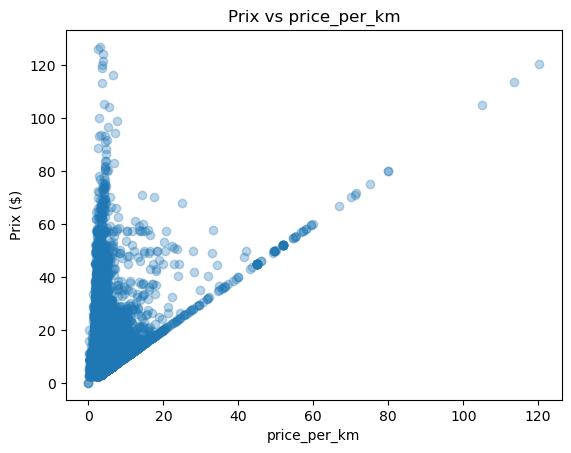

In [71]:
plt.scatter(df['price_per_km'], df['fare_amount'], alpha=0.3)
plt.xlabel('price_per_km')
plt.ylabel('Prix ($)')
plt.title('Prix vs price_per_km')
plt.show()

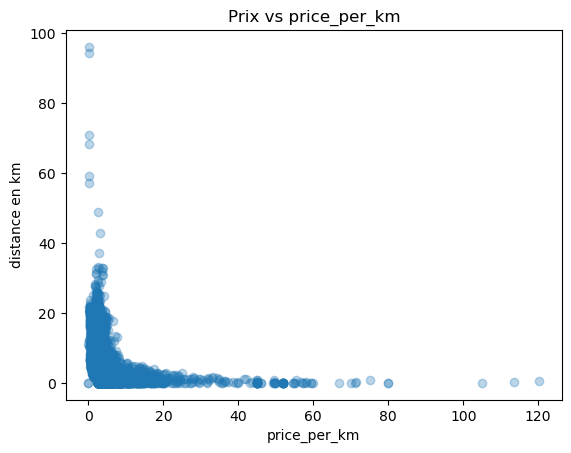

In [72]:
plt.scatter(df['price_per_km'], df['distance_km'], alpha=0.3)
plt.xlabel('price_per_km')
plt.ylabel('distance en km')
plt.title('Prix vs price_per_km')
plt.show()

In [73]:
df.to_csv("Data/clean_data.csv", index=False)

# PCA

Variance expliquée par les 2 axes : [0.30606756 0.30137297]


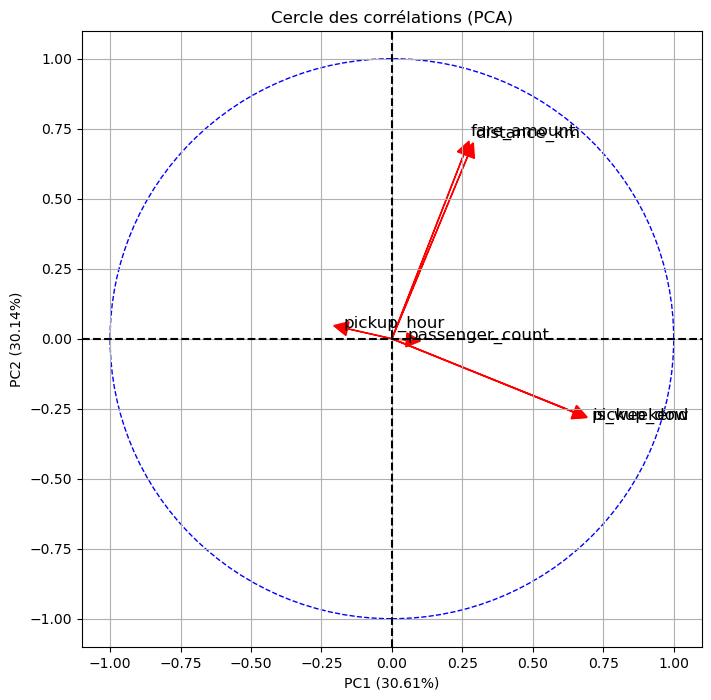

In [75]:
# Charger ton dataset propre
df = pd.read_csv("Data/clean_data.csv")

# Sélection des variables quantitatives utiles
features = ['passenger_count', 'distance_km', 'pickup_hour', 'pickup_dow', 'is_weekend', 'fare_amount']
X = df[features]

# 1. Normalisation (centrer-réduire les variables)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. Appliquer PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print("Variance expliquée par les 2 axes :", pca.explained_variance_ratio_)

# 3. Cercle de corrélation
pcs = pca.components_

plt.figure(figsize=(8,8))

# --- Cercle unité ---
circle = plt.Circle((0,0), 1, color='blue', fill=False, linestyle="--")
plt.gca().add_artist(circle)

# --- Flèches pour chaque variable ---
for i, (x, y) in enumerate(zip(pcs[0, :], pcs[1, :])):
    plt.arrow(0, 0, x, y, head_width=0.05, head_length=0.05, fc='red', ec='red')
    plt.text(x*1.1, y*1.1, features[i], fontsize=12)

# --- Axes ---
plt.axhline(0, color='black', linestyle='--')
plt.axvline(0, color='black', linestyle='--')

# --- Paramètres ---
plt.xlabel("PC1 (%.2f%%)" % (pca.explained_variance_ratio_[0]*100))
plt.ylabel("PC2 (%.2f%%)" % (pca.explained_variance_ratio_[1]*100))
plt.title("Cercle des corrélations (PCA)")
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.grid()
plt.show()

**Interpretation :** 
Le cercle de corrélation montre que distance_km et fare_amount sont fortement positivement corrélés avec le premier axe principal (PC1), indiquant qu'ils varient ensemble . La variable pickup_latend est fortement corrélée avec le second axe (PC2) et orthogonale aux variables du PC1.
et orthogonale aux variables du PC1.

## Phase 4 : Modeling

In [78]:
df1 = df.copy()

In [79]:
df1 = df1.drop(columns=['key','pickup_datetime', 'pickup_longitude', 'pickup_latitude','dropoff_longitude', 'dropoff_latitude'])

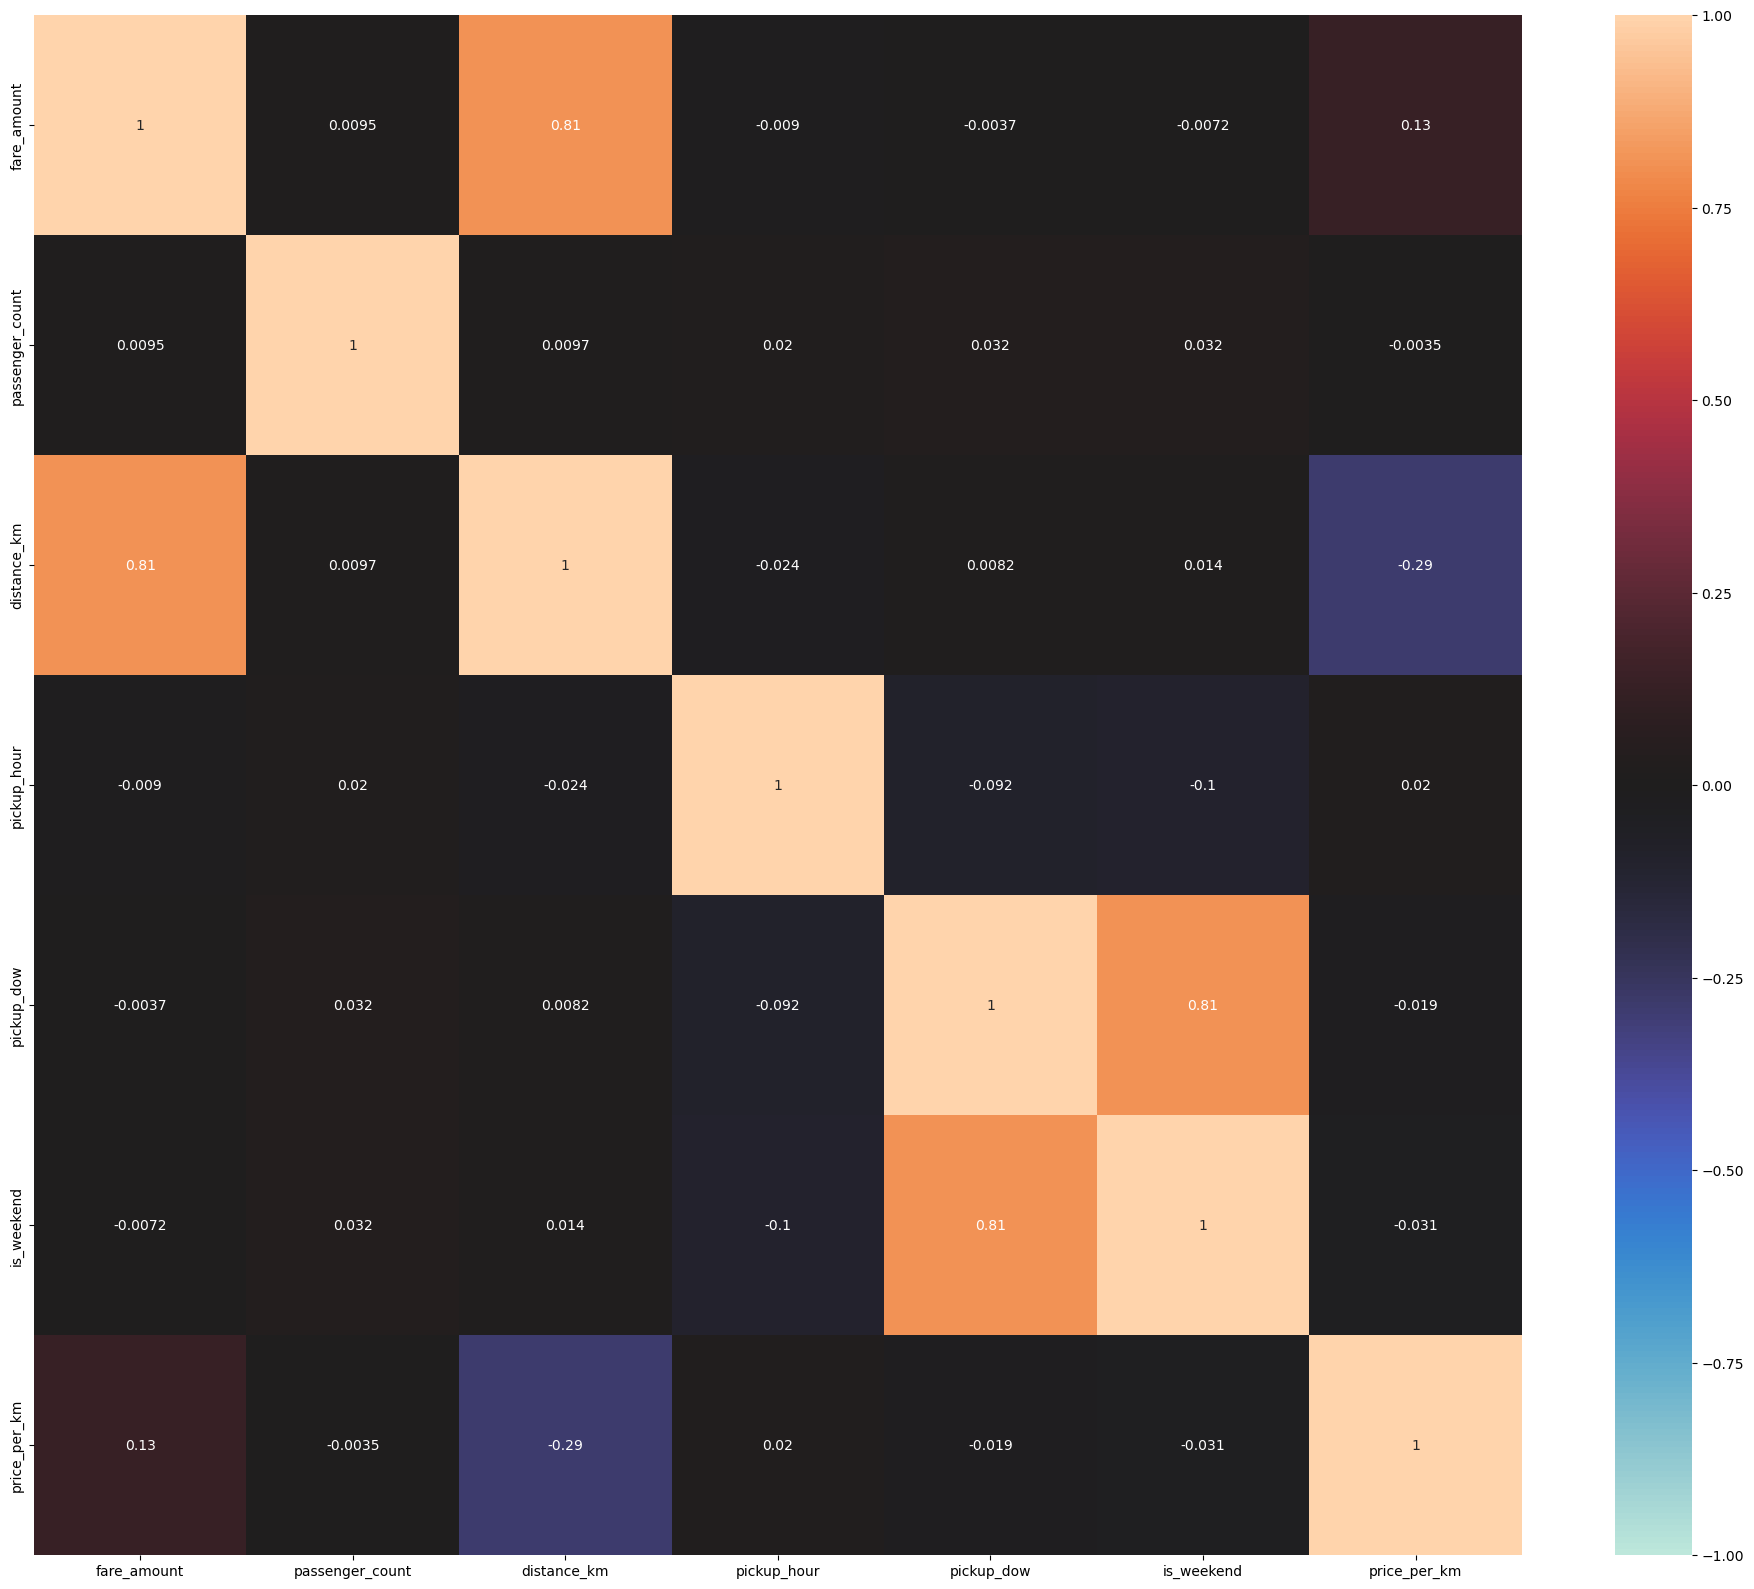

In [80]:
plt.figure(figsize=[24,20])
sns.heatmap(df1.corr(), annot=True, vmin=-1, vmax=1, center=0) 
plt.show()

In [81]:
df1.head()

,fare_amount,passenger_count,distance_km,pickup_hour,pickup_dow,is_weekend,price_per_km
0,7.5,1.0,1.683323,19,3,0,4.455474
1,7.7,1.0,2.457590,20,4,0,3.133151
2,12.9,1.0,4.117407,13,6,1,3.133040
3,5.3,3.0,5.726622,8,4,0,0.925502
4,16.0,5.0,1.228574,17,3,0,13.023229


In [82]:
df = df.drop(columns=['key'])

features = ['passenger_count', 'distance_km', 'pickup_hour', 'pickup_dow', 'is_weekend']
target = 'fare_amount'

X = df[features]
y = df[target]

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Standardisation :

In [85]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Supervised :

## 1. Regression lineaire :

In [88]:
pipeline = LinearRegression()
pipeline.fit(X_train_scaled, y_train)

LinearRegression()

In [89]:
y_pred = pipeline.predict(X_test_scaled)

In [90]:
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("RMSE : ", rmse)
print("MAE : ", mae)
print("R2 : ", r2)

RMSE :  5.1407899824731045
MAE :  2.769071985174258
R2 :  0.7044402414003884


C:\Users\hanin\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## 2. XGBOOST :

In [92]:
xgb_model = xgb.XGBRegressor(
    n_estimators=200,  
    learning_rate=0.1,  
    max_depth=6,      
    subsample=0.8,     
    colsample_bytree=0.8,
    random_state=42
)

In [93]:
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, ...)

In [94]:
y_pred = xgb_model.predict(X_test)

In [95]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("MSE:", mse)
print("RMSE:", rmse)
print("R²:", r2)

MSE: 26.463160583950067
RMSE: 5.144235665669883
R²: 0.7040439028620689


## 3. Random Forest + Gradient Boosting

In [97]:
models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, random_state=42)
}

results = {}

In [98]:
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

In [99]:
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results[name] = {"MAE": mae, "RMSE": rmse, "R2": r2}
    print(f"\n{name}:")
    print(f"  MAE = {mae:.2f}")
    print(f"  RMSE = {rmse:.2f}")
    print(f"  R² = {r2:.3f}")


Random Forest:
  MAE = 2.96
  RMSE = 5.38
  R² = 0.677

Gradient Boosting:
  MAE = 2.65
  RMSE = 5.01
  R² = 0.719


In [116]:
# Récupérer le modèle gradient boosting
gb_model = models["Gradient Boosting"]

# S'assurer qu'il est déjà entraîné
gb_model.fit(X_train, y_train)

GradientBoostingRegressor(n_estimators=200, random_state=42)

### Save the model :

In [118]:
import joblib
joblib.dump(gb_model, "uber_GB_model.pkl")

['uber_GB_model.pkl']

In [120]:
# Importance des features
importance = gb_model.feature_importances_

# Mettre dans un DataFrame pour plus de clarté
feat_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': importance})
feat_importance = feat_importance.sort_values(by='Importance', ascending=False)
print(feat_importance)

           Feature  Importance
1      distance_km    0.983601
2      pickup_hour    0.012134
3       pickup_dow    0.002213
0  passenger_count    0.001524
4       is_weekend    0.000528


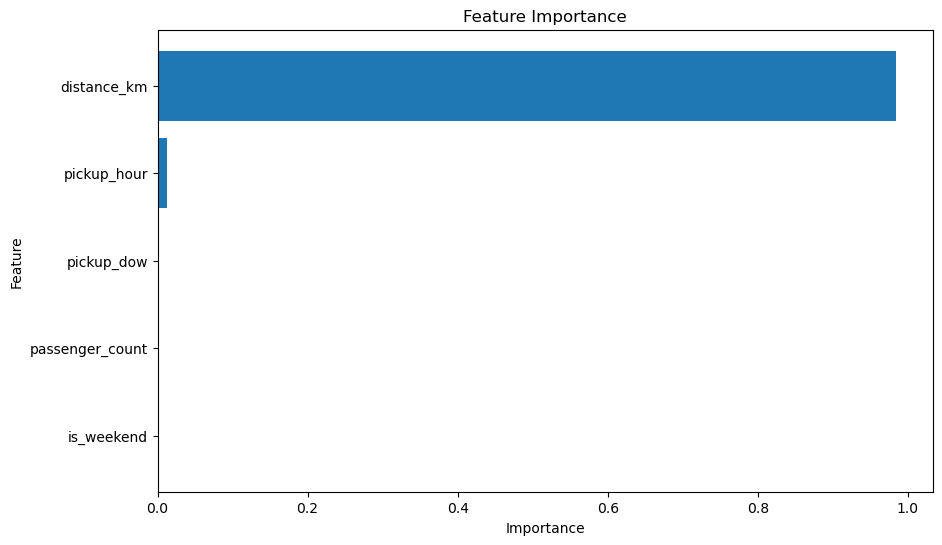

In [122]:
plt.figure(figsize=(10,6))
plt.barh(feat_importance['Feature'], feat_importance['Importance'])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance")
plt.gca().invert_yaxis()  # Pour avoir la plus importante en haut
plt.show()

## 4. KNN :

## Choix de k :

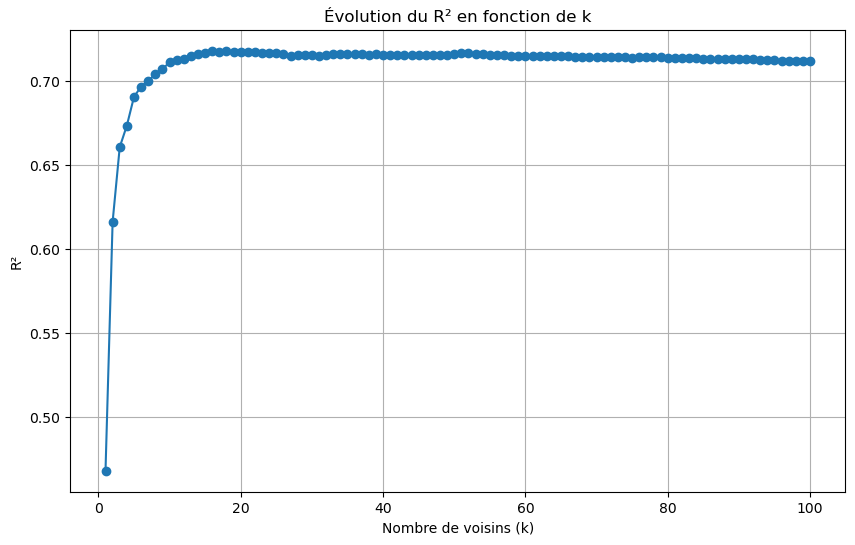

Meilleur k = 18 avec R² = 0.718


In [126]:
r2_scores = []
k_values = range(1, 101)  # de 1 à 100

for k in k_values:
    knn_model = KNeighborsRegressor(n_neighbors=k)
    knn_model.fit(X_train_scaled, y_train)  
    y_pred = knn_model.predict(X_test_scaled)
    
    # Calcul R²
    r2 = r2_score(y_test, y_pred)
    r2_scores.append(r2)

# --- Tracer la courbe ---
plt.figure(figsize=(10,6))
plt.plot(k_values, r2_scores, marker='o')
plt.title("Évolution du R² en fonction de k")
plt.xlabel("Nombre de voisins (k)")
plt.ylabel("R²")
plt.grid(True)
plt.show()

# Optionnel : afficher le meilleur k
best_k = k_values[np.argmax(r2_scores)]
best_r2 = max(r2_scores)
print(f"Meilleur k = {best_k} avec R² = {best_r2:.3f}")

## choix de distance : 

In [128]:
distance_metrics = [
    ("euclidean", {"metric": "minkowski", "p": 2}),
    ("manhattan", {"metric": "minkowski", "p": 1}),
    ("chebyshev", {"metric": "chebyshev"}),
    ("cosine", {"metric": "cosine"}),
    ("minkowski_p3", {"metric": "minkowski", "p": 3})
]


for name, params in distance_metrics:
    knn = KNeighborsRegressor(n_neighbors=18, **params)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f"{name} → MSE = {mse:.3f}")

euclidean → MSE = 25.316
manhattan → MSE = 25.587
chebyshev → MSE = 25.208
cosine → MSE = 32.128
minkowski_p3 → MSE = 25.311


**Interpretation** 
On admet la distance Chebychev car elle present le plus bs MSE.

In [130]:
knn = KNeighborsRegressor(n_neighbors=18, metric='chebyshev')
knn_model.fit(X_train_scaled, y_train)

KNeighborsRegressor(n_neighbors=100)

In [131]:
y_pred = knn_model.predict(X_test_scaled)

In [132]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error (MAE): {mae:.2f} $')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f} $')
print(f"R² (Coefficient de Détermination) = {r2:.3f}")

Mean Absolute Error (MAE): 2.69 $
Root Mean Squared Error (RMSE): 5.08 $
R² (Coefficient de Détermination) = 0.712


# Unsupervised :
## 1. kMeans

In [134]:
# Variables pertinentes pour le clustering
features = ["distance_km", "fare_amount", "passenger_count", "pickup_hour", "is_weekend", "pickup_dow"]
X = df[features]

In [135]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

   Nombre de clusters (k)        Inertia
0                       2  187588.622133
1                       3  141193.311477
2                       4  115124.875595
3                       5   98570.866506
4                       6   88930.400850


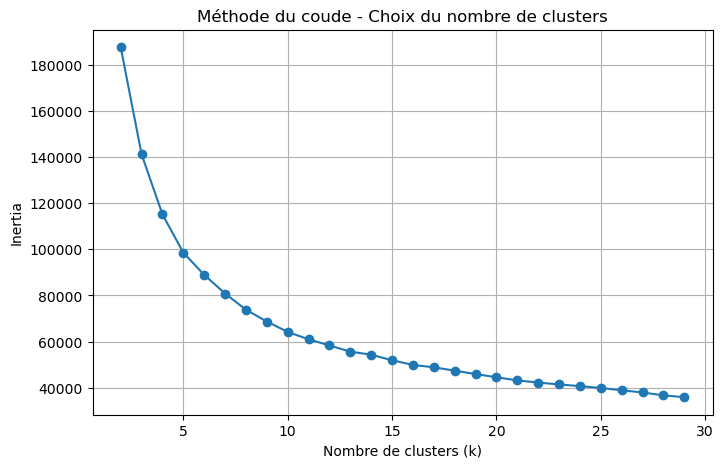

In [144]:
inertia = []
K = range(2, 30)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

results_df = pd.DataFrame({
    "Nombre de clusters (k)": list(K),
    "Inertia": inertia
})

print(results_df.head())


# Tracer la courbe
plt.figure(figsize=(8,5))
plt.plot(K, inertia, marker="o")
plt.title("Méthode du coude - Choix du nombre de clusters")
plt.xlabel("Nombre de clusters (k)")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()

    Nombre de clusters (k)  Silhouette Score
0                        2          0.351513
1                        3          0.381616
2                        4          0.405237
3                        5          0.317310
4                        6          0.308259
5                        7          0.311711
6                        8          0.321842
7                        9          0.291263
8                       10          0.299452
9                       11          0.287047
10                      12          0.291160
11                      13          0.269981
12                      14          0.286015
13                      15          0.260327
14                      16          0.266261
15                      17          0.266353
16                      18          0.266969
17                      19          0.267871
18                      20          0.261589


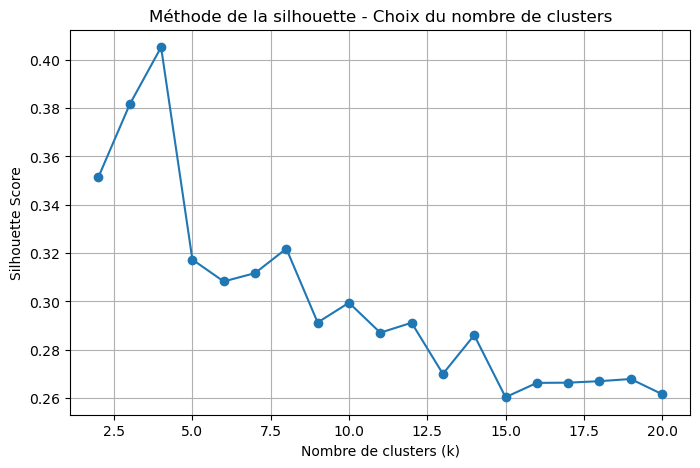

Meilleur k (score de silhouette max) = 4 avec score = 0.405


In [146]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pandas as pd
import matplotlib.pyplot as plt

silhouette_scores = []
K = range(2, 21)  # tester de 2 à 20 clusters

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    labels = kmeans.labels_
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)

#  Mettre dans un tableau
results_df = pd.DataFrame({
    "Nombre de clusters (k)": list(K),
    "Silhouette Score": silhouette_scores
})
print(results_df)

# Tracer la courbe
plt.figure(figsize=(8,5))
plt.plot(K, silhouette_scores, marker="o")
plt.title("Méthode de la silhouette - Choix du nombre de clusters")
plt.xlabel("Nombre de clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

# Afficher le meilleur k
best_k = K[silhouette_scores.index(max(silhouette_scores))]
print(f"Meilleur k (score de silhouette max) = {best_k} avec score = {max(silhouette_scores):.3f}")

In [147]:
k_optimal = 3 
kmeans = KMeans(n_clusters=k_optimal, random_state=42, n_init=10)
df["cluster"] = kmeans.fit_predict(X_scaled)

In [148]:
df.groupby("cluster")[["distance_km", "fare_amount"]].agg(["mean", "min", "max", "std"])

distance_km                           fare_amount               \
               mean  min        max       std        mean  min     max   
cluster                                                                  
0         13.512844  0.0  96.021362  6.136551   38.380748  5.0  126.83   
1          2.514106  0.0  15.953255  1.813492    9.150041  0.0   45.00   
2          2.768507  0.0  17.171173  2.042359    9.415285  0.0   49.57   

                    
               std  
cluster             
0        14.245670  
1         4.512144  
2         4.915574

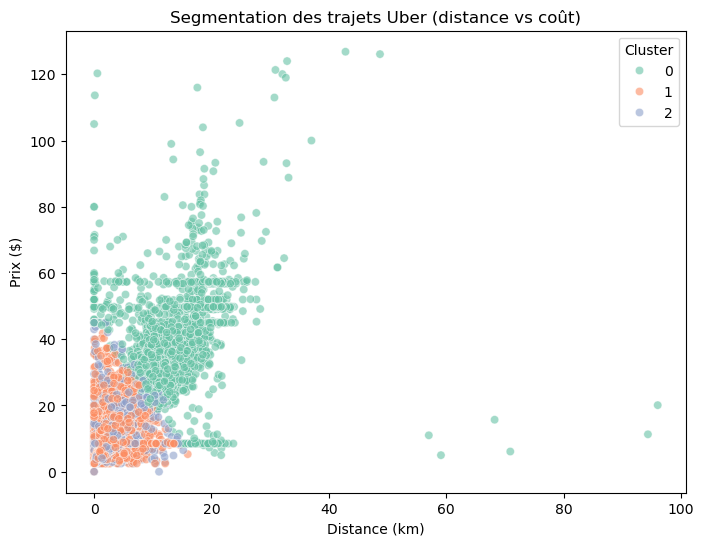

In [150]:
plt.figure(figsize=(8,6))
sns.scatterplot(x="distance_km", y="fare_amount", hue="cluster", data=df, palette="Set2", alpha=0.6)
plt.title("Segmentation des trajets Uber (distance vs coût)")
plt.xlabel("Distance (km)")
plt.ylabel("Prix ($)")
plt.legend(title="Cluster")
plt.show()

**Interprétation des résultats**
Cluster 0 (vert clair dans ton graphe)

Distance moyenne : ≈ 2.8 km

Prix moyen : ≈ 9.3 $

→ Petits trajets urbains (très courts, pas chers).

Cluster 1 (orange clair)

Distance moyenne : ≈ 2.8 km (très proche du cluster 0 !)

Prix moyen : ≈ 9.6 $

→ Très similaire au cluster 0 (peut-être une séparation artificielle de KMeans).

Cluster 2 (bleu clair)

Distance moyenne : ≈ 2.5 km

Prix moyen : ≈ 9.0 $

→ Encore un cluster de petits trajets urbains.

Cluster 3 (rose)

Distance moyenne : ≈ 14.3 km

Prix moyen : ≈ 38.7 $

Max distance : 96 km / Max prix : 126 $

→ Trajets longs et chers, ce cluster est clairement distinct.

Les clusters 0, 1 et 2 représentent tous des trajets courts et peu chers → KMeans les a séparés mais en pratique ils se ressemblent énormément.

Le cluster 3 regroupe les trajets longs/chers, qui sont bien distincts.

d'où k=3 suffi pour l’analyse métier (courts vs moyens vs longs).

In [164]:
def map_cluster_to_category(cluster):
    if cluster == 1:
        return 'long'
    elif cluster in [0, 2]:
        return 'court'

df['pred_category'] = df['cluster'].apply(map_cluster_to_category)

In [166]:
def assign_true_category(distance):
    if distance < 5:
        return 'court'
    elif distance < 12:
        return 'moyen'
    else:
        return 'long'

df['true_category'] = df['distance_km'].apply(assign_true_category)

In [168]:
from sklearn.metrics import confusion_matrix
import pandas as pd

cm = confusion_matrix(df['true_category'], df['pred_category'],
                      labels=['court','moyen','long'])
cm_df = pd.DataFrame(cm,
                     index=['Vrai_court','Vrai_moyen','Vrai_long'],
                     columns=['Pred_court','Pred_moyen','Pred_long'])
print(cm_df)


            Pred_court  Pred_moyen  Pred_long
Vrai_court       11558           0      24266
Vrai_moyen        3120           0       2838
Vrai_long         1467           0         17


# Phase 5 : Evaluation

In [174]:
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=200,learning_rate=0.1, max_depth=6,subsample=0.8,colsample_bytree=0.8,random_state=42),
    'KNN': KNeighborsRegressor(n_neighbors=18, metric='chebyshev')
}

In [178]:
# Fonction d'évaluation
def evaluate_model(model, model_name, X_train, X_test, y_train, y_test):
    start_time = time.time()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Validation croisée
    cv_scores = cross_val_score(model, X_scaled, y, cv=5, scoring='r2')
    cv_mean, cv_std = cv_scores.mean(), cv_scores.std()
    
    execution_time = time.time() - start_time
    return {
        'Model': model_name,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'CV R2 Mean': cv_mean,
        'CV R2 Std': cv_std,
        'Time (s)': execution_time
    }

In [182]:

# Évaluation des modèles de régression
import time
results = []
for name, model in models.items():
    result = evaluate_model(model, name, X_train, X_test, y_train, y_test)
    results.append(result)
    print(f"{name}: RMSE = {result['RMSE']:.2f}, MAE = {result['MAE']:.2f}, R2 = {result['R2']:.3f}, "
      f"CV R2 = {result['CV R2 Mean']:.3f} (±{result['CV R2 Std']:.3f}), Time = {result['Time (s)']:.2f}s")

Linear Regression: RMSE = 5.14, MAE = 2.77, R2 = 0.704, CV R2 = 1.000 (±0.000), Time = 0.27s
Random Forest: RMSE = 5.38, MAE = 2.96, R2 = 0.677, CV R2 = 1.000 (±0.000), Time = 81.11s
Gradient Boosting: RMSE = 5.01, MAE = 2.65, R2 = 0.719, CV R2 = 1.000 (±0.000), Time = 78.13s
XGBoost: RMSE = 5.14, MAE = 2.72, R2 = 0.704, CV R2 = 0.982 (±0.004), Time = 29.57s
KNN: RMSE = 5.02, MAE = 2.71, R2 = 0.718, CV R2 = 0.980 (±0.004), Time = 4.13s


In [184]:
inertia = kmeans.inertia_
print(f"Clustering Inertia: {inertia:.2f}")

Clustering Inertia: 141193.31


In [186]:
from sklearn.metrics import silhouette_score

score = silhouette_score(X_scaled, kmeans.labels_)
print(score)

0.3816160684959492


In [188]:
# Sauvegarde des résultats
results_df = pd.DataFrame(results)
results_df.to_csv('model_evaluation_results.csv', index=False)
print("\nResults saved to 'model_evaluation_results.csv'")


Results saved to 'model_evaluation_results.csv'


In [190]:
# Meilleur modèle basé sur R2
best_model = max(results, key=lambda x: x['R2'])
print(f"\nBest Model: {best_model['Model']} with R2 = {best_model['R2']:.3f}")


Best Model: Gradient Boosting with R2 = 0.719


In [192]:
r=pd.read_csv("model_evaluation_results.csv")

In [194]:
r.head()

,Model,RMSE,MAE,R2,CV R2 Mean,CV R2 Std,Time (s)
0,Linear Regression,5.140790,2.769072,0.704440,1.000000,0.000000,0.268546
1,Random Forest,5.375570,2.959338,0.676827,0.999977,0.000012,81.114321
2,Gradient Boosting,5.011494,2.648418,0.719121,0.999958,0.000010,78.126997
3,XGBoost,5.144236,2.715077,0.704044,0.981607,0.004054,29.572604
4,KNN,5.020803,2.710334,0.718076,0.980222,0.003568,4.132143


# Phase 6. Deploiement

In [ ]:


import streamlit as st
import joblib
import pandas as pd
from geopy.distance import geodesic
from datetime import datetime
import folium
from streamlit_folium import st_folium
import openrouteservice

# --- Load model ---
model = joblib.load("uber_GB_model.pkl")
features = ['passenger_count', 'distance_km', 'pickup_hour', 'pickup_dow', 'is_weekend']

# --- Streamlit settings ---
st.set_page_config(page_title="Uber Fare Prediction", layout="centered")
st.title("Uber Fare Prediction with Real Route 🗺️")

# --- OpenRouteService client ---
ORS_API_KEY = "eyJvcmciOiI1YjNjZTM1OTc4NTExMTAwMDFjZjYyNDgiLCJpZCI6IjZmYTExYzcyZjhlNTRkMWVhYTllMmZmMmJhMDU1YjVkIiwiaCI6Im11cm11cjY0In0="  # Replace with your key
client = openrouteservice.Client(key=ORS_API_KEY)

# --- Initialize session state ---
if "pickup" not in st.session_state:
    st.session_state.pickup = None
if "dropoff" not in st.session_state:
    st.session_state.dropoff = None

st.write("📍 Click once for **Pickup** and again for **Dropoff** on the map.")

# --- Create Folium map ---
m = folium.Map(location=[40.7128, -74.0060], zoom_start=12)

# Add markers if already selected
if st.session_state.pickup:
    folium.Marker(location=st.session_state.pickup, popup="Pickup", icon=folium.Icon(color="green")).add_to(m)

if st.session_state.dropoff:
    folium.Marker(location=st.session_state.dropoff, popup="Dropoff", icon=folium.Icon(color="red")).add_to(m)

    # --- Draw real route using ORS ---
    try:
        coords = [
            (st.session_state.pickup[1], st.session_state.pickup[0]),  # ORS uses (lon, lat)
            (st.session_state.dropoff[1], st.session_state.dropoff[0])
        ]
        route = client.directions(coords, profile='driving-car', format='geojson')
        geometry = route['features'][0]['geometry']['coordinates']
        # Convert to (lat, lon)
        route_latlon = [(lat, lon) for lon, lat in geometry]
        folium.PolyLine(route_latlon, color="blue", weight=5, opacity=0.7).add_to(m)
        distance_km = route['features'][0]['properties']['segments'][0]['distance'] / 1000
    except Exception as e:
        st.warning(f"Route generation failed: {e}")
        distance_km = geodesic(st.session_state.pickup, st.session_state.dropoff).km
else:
    distance_km = 0

# --- Display map once ---
map_data = st_folium(m, width=700, height=500)

# --- Detect clicks ---
if map_data and map_data["last_clicked"]:
    lat, lon = map_data["last_clicked"]["lat"], map_data["last_clicked"]["lng"]
    if st.session_state.pickup is None:
        st.session_state.pickup = (lat, lon)
        st.success(f"✅ Pickup selected: {st.session_state.pickup}")
    elif st.session_state.dropoff is None:
        st.session_state.dropoff = (lat, lon)
        st.success(f"✅ Dropoff selected: {st.session_state.dropoff}")
    else:
        st.warning("🔄 Resetting pickup & dropoff… Click again to choose new points.")
        st.session_state.pickup = (lat, lon)
        st.session_state.dropoff = None

# --- Passenger count ---
passenger_count = st.number_input("Passenger Count", min_value=1, max_value=8, value=1)

# --- Date & Time ---
pickup_datetime = datetime.now()
pickup_hour = pickup_datetime.hour
pickup_dow = pickup_datetime.weekday()
is_weekend = 1 if pickup_dow in [5, 6] else 0

# --- Prediction ---
if st.button("Predict Fare"):
    if st.session_state.pickup and st.session_state.dropoff:
        X = pd.DataFrame([[passenger_count, distance_km, pickup_hour, pickup_dow, is_weekend]], columns=features)
        predicted_fare = model.predict(X)[0]
        st.info(f"🛣️ Distance: {distance_km:.2f} km ")
        st.success(f"💵 Predicted Fare: ${predicted_fare:.2f}")
    else:
        st.error("⚠️ Please select both pickup and dropoff on the map.")


